In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import doc_retention_utils as dr
from lmfit import Model
from scipy.stats import chi2

# plt.style.use("ggplot")

## Modelling retention using Vollenweider

According to Vollenweider (1975), the relationship between lake inflow and outflow concentrations for a non-volatile substance is given by

$$C_{lake} = \frac{C_{in}}{1 + \sigma \tau}$$

where $\tau$ is the water residence time and $\sigma$ is a parameter representing the rate of internal cycling and removal. See [here](https://nivanorge.github.io/teotil2/pages/05_retention.html) for a derivation of this (especially equation 7) and also the paper by [Ahlgren et al. (1988)](https://www.researchgate.net/publication/227035110_Empirical_and_Theoretical_Models_of_Phosphorus_Loading_Retention_and_Concentration_Vs_Lake_Trophic_State), which provides a nice historical overview.

In practice, the parameter $\sigma$ is often not constant and the factors controlling its variation are not well understood. In the original Vollenweider papers focusing on phosphorus, the only reasonable predictor of $\sigma$ was found to be a relationship with $\tau$

$$\sigma = \frac{1}{\tau ^ {0.5}}$$

More generally, many papers choose to model $\sigma$ as $k \tau ^m$. Substituting this into the first equation above gives

$$C_{lake} = \frac{C_{in}}{1 + k \tau ^{(1 + m)}}$$

Note, however, that in principle $\sigma$ and $\frac{1}{\tau}$ have the same dimensions, so using a fractional exponent creates some problems with dimensional consistency (although Vollenweider considered this to be an acceptable empirical "shortcut"). 

Given measured data for $C_{lake}$, $C_{in}$ and $\tau$, we therefore usually want to either:

 1. Use the first equation and estimate $\sigma$ as a constant (referred to as *"Option 1"* below), or
 
 2. Model $\sigma$ as a function of $\tau$ and estimate $k$ and $m$ (referred to as *"Option 2"* below)
 
To reduce the dimensionality of the problem, instead of modelling $C_{out}$ as a function of both $C_{in}$ and $\tau$, we can divide by $C_{in}$ to get the transmission factor for each lake, and then fit this as a function of $\tau$ alone (see also the post [here](https://stackoverflow.com/questions/73825528/fitting-a-curve-to-data-inconsistent-results) for some further relevant details).

`lmfit` provides a general approach for fitting non-linear functions. However, when rearranged to give transmission as a function of $\tau$, these equations can also be fitted using simple linear regression

 * For constant $\sigma$ (*Option 1*)

$$\frac{C_{in}}{C_{out}} = \sigma \tau + 1$$

 * For $\sigma$ as a function of $\tau$ (*Option 2*)

$$log \left( \frac{L_{in}}{L_{out}} - 1 \right) = log(k) + (1 + m) log(\tau)$$

I will use `lmfit` here for simplicity, but `statsmodels` might provide slightly richer output.

# Load Evans data

**Note:** We have added the Langtjern (Norway) DOC budget to this dataset

Drop lakes which are net producers of DOC rather than net consumers, as defined by Evans et al. (2017): drop when retention is less han 0.1, i.e. transmission is greater than 0.9

In [3]:
data_fpath = r"data/evans_2017_doc_retention_cleaned.csv"
df = pd.read_csv(data_fpath)

# countries_to_keep = ["Norway", "Finland", "Sweden", "Canada"]
# df = df.query("country in @countries_to_keep")

df.sort_values("tau", inplace=True)

# Drop any NANs in tau or RDOC
df = df.dropna(how="any", subset=["tau", "RDOC"])

# Drop negative retention values
# N.B. use same definition as Evans et al.
df = df.query("RDOC > 0.1")

# Calculate transmission
df["TDOC"] = 1 - df["RDOC"]

df.head()

,name,country,type,nutrient_status,tau,DOC_in,DOC_out,TDOC,RDOC,Notes,DOC_type
27,Røynelandsvatn,Norway,Lake,Oligotrophic,0.10,6.37,5.49,0.86,0.14,NaN,DOC sink
35,Black Esk,UK,Reservoir,Oligotrophic,0.12,9.25,7.30,0.79,0.21,NaN,DOC sink
33,Gäddtjärn,Sweden,Lake,Oligotrophic,0.13,15.00,11.72,0.78,0.22,NaN,DOC sink
21,Alinen Rautjarvi,Finland,Lake,Oligotrophic,0.13,2.90,2.39,0.83,0.17,NaN,DOC sink
48,Burr Oak,USA,Reservoir,Mesotrophic,0.18,2.13,1.46,0.69,0.31,NaN,DOC sink


# Also load in newly gathered river data

In [4]:
riv_df = pd.read_csv(r'data/review_instream_doc_retention_summary.csv')
riv_df.rename({'Transmission (M_out/M_in)': 'mo_mi'}, axis=1, inplace=True)
riv_df.head()

,Site,mo_mi,t (days),Stream order,Ref
0,"NE Spain, site and sample median",1.000,0.250,Reaches in 2nd-4th order streams,Casas-Ruiz et al. (2017)
1,"Wood Brook, England",0.983,0.091,1st order,Khamis et al. (2021)
2,"Site average, small Alaskan streams with natur...",0.919,0.002,Headwaters (order not given),Fellman et al. (2009)
3,"Creeping Swamp, North Carolina, USA",0.360,9.259,3rd,Mulholland (1981)
4,"Fort River, Massachusetts, USA",0.960,0.132,4th,Fisher (1977)


# Fit TOC

We considered grouping the lakes e.g. by geoclimatic region, but for now we will consider all lakes as one, as done by previous authors.

In [5]:
print(len(df), "lakes in the TOC dataset.")

print("\n\nFit for 'option 1'")
toc_fit1 = dr.fit_model(dr.transmission_sigma_constant, df, "tau", "TDOC")

print("\n\nFit for 'option 2'")
toc_fit2 = dr.fit_model(dr.transmission_sigma_as_func_of_tau, df, "tau", "TDOC")

print("\n\nFit for 'exponential decay'")
toc_fit_exp1 = dr.fit_model(dr.transmission_k_constant, df, "tau", "TDOC")

print("\n\nFit for 'exponential decay'")
toc_fit_exp2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df, "tau", "TDOC")

47 lakes in the TOC dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 47
    # variables        = 1
    chi-square         = 1.85158835
    reduced chi-square = 0.04025192
    Akaike info crit   = -150.002877
    Bayesian info crit = -148.152729
    R-squared          = -0.39457220
[[Variables]]
    sigma:  0.40177571 +/- 0.06032258 (15.01%) (init = 1)
R2: -0.37


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 47
    # variables        = 2
    chi-square         = 0.69022856
    reduced chi-square = 0.01533841
    Akaike info crit   = -194.381364
    Bayesian info crit = -190.681069
    R-squared          = 0.48013631
[[Variables]]
    k:  0.65659565 +/- 0.05442574 (8.29%) (init = 1)
    m: -0.70320370 +/- 0.05577054 (7.93%)

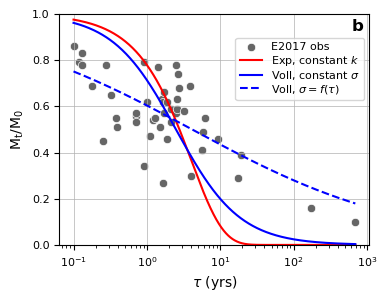

In [13]:
# Plot all models on one plot

fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sn.scatterplot(data=df, x='tau', y='TDOC', color='0.4', label='E2017 obs') 

# Plot each model's fit
tau_values = np.linspace(df['tau'].min(), df['tau'].max(), 100000)
# tau_values = np.logspace(np.log10(riv_df['t (days)'].min()/365), np.log10(df['tau'].max()), 1000)
ax.plot(tau_values, toc_fit_exp1.eval(tau=tau_values), label='Exp, constant $k$', color='red')
ax.plot(tau_values, toc_fit1.eval(tau=tau_values), label=r'Voll, constant $\sigma$', color='blue')
ax.plot(tau_values, toc_fit2.eval(tau=tau_values), ls='--', label=r'Voll, $\sigma = f(\tau$)', color='blue')
# ax.plot(tau_values, toc_fit_exp2.eval(tau=tau_values), ls='--', label=r'Exp, $k = f(\tau$)', color='red')

# Also plot implied results of Catalan's regression, when rearranged for Cout/Cin
# trans_catalan = np.exp(-0.38 * tau_values ** 0.55)
# ax.plot(tau_values, trans_catalan, ls='--', label="Exponential (Catalan et al. 2016)", color='orange')

# # Add newly gathered stream metabolism data
# new_color = 'greenyellow'
# ax.scatter(riv_df['t (days)'] / 365, riv_df['mo_mi'], marker='^', color=new_color, edgecolors='k', label='Additional river data (not used in fitting)')

plt.ylim(0, 1)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_t/M_0}$', size=10)
plt.xlabel((r'$\tau$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(0.55, 0.92), labelspacing=0.1)

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, 'b', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r'graphs/model_results_evans-data_all-countries-all-taus.png', bbox_inches='tight')

# Show plot
plt.show()

In [7]:
print("\nLRT constant sigma vs time-varying sigma:")
dr.likelihood_ratio_test(toc_fit1, toc_fit2)


LRT constant sigma vs time-varying sigma:
Likelihood Ratio: 1.161359791451508
Degrees of Freedom: 1
P-value: 0.281


In [8]:
print("\nLRT constant k vs time-varying k:")
dr.likelihood_ratio_test(toc_fit_exp1, toc_fit_exp2)


LRT constant k vs time-varying k:
Likelihood Ratio: 1.8494928399570696
Degrees of Freedom: 1
P-value: 0.174


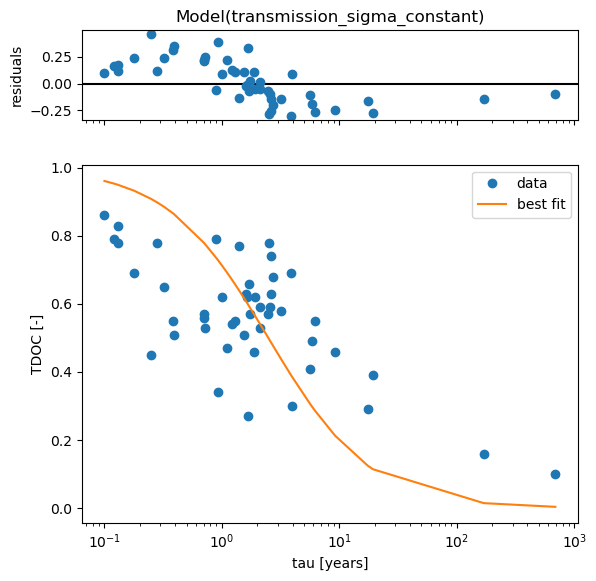

In [9]:
# Plot fit
toc_fit1.plot(xlabel="tau [years]", ylabel="TDOC [-]");
plt.xscale('log')

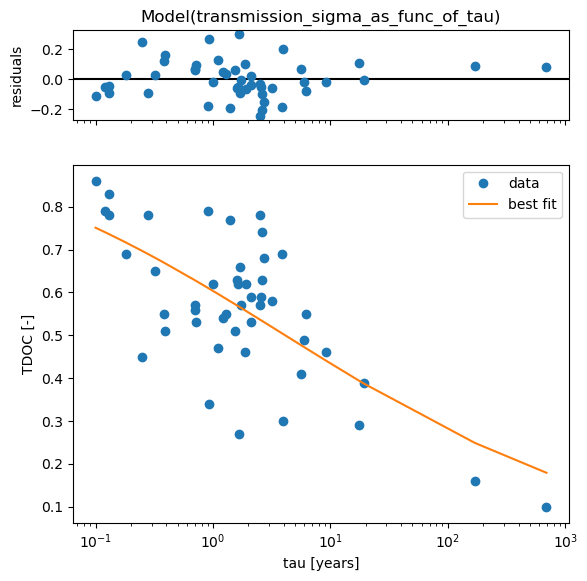

In [10]:
# Plot fit
toc_fit2.plot(xlabel="tau [years]", ylabel="TDOC [-]");
plt.xscale('log')

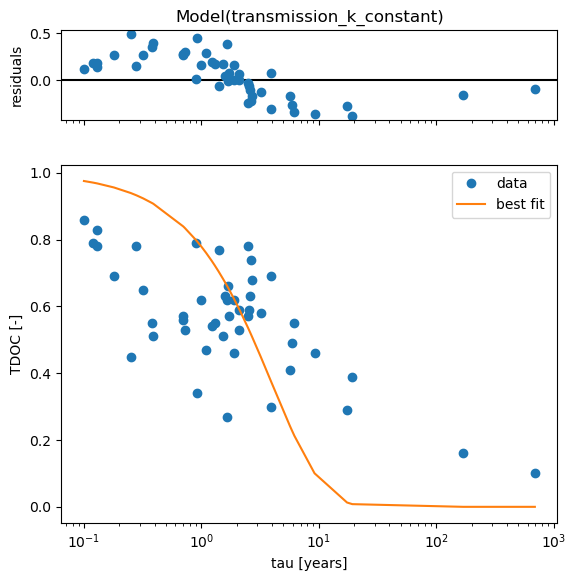

In [11]:
# Plot fit
toc_fit_exp1.plot(xlabel="tau [years]", ylabel="TDOC [-]");
plt.xscale('log')

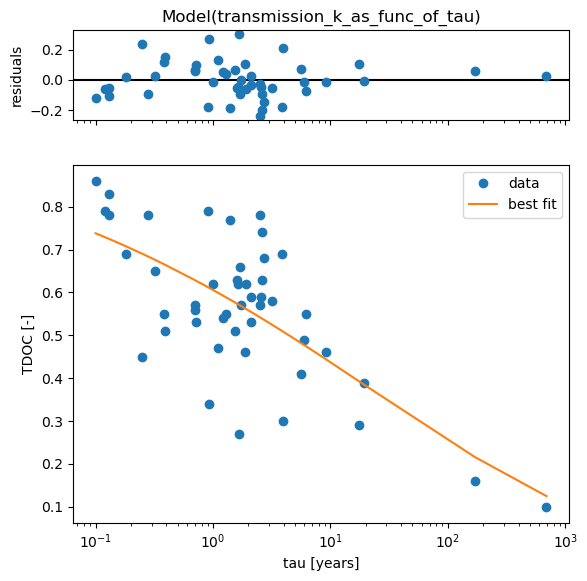

In [12]:
# Plot fit
toc_fit_exp2.plot(xlabel="tau [years]", ylabel="TDOC [-]");
plt.xscale('log')

### 6.2 Fit TOC, all countries, tau < 10 years

In [13]:
tau_upper = 10
short_tau_df = df.loc[df['tau'] < tau_upper].copy()

print(len(short_tau_df), "lakes in the TOC dataset.")

print("\n\nFit for 'option 1'")
short_fit1 = dr.fit_model(dr.transmission_sigma_constant, short_tau_df, "tau", "TDOC")

print("\n\nFit for 'option 2'")
short_fit2 = dr.fit_model(dr.transmission_sigma_as_func_of_tau, short_tau_df, "tau", "TDOC")

print("\n\nFit for 'exponential decay'")
short_fit_exp1 = dr.fit_model(dr.transmission_k_constant, short_tau_df, "tau", "TDOC")

print("\n\nFit for 'exponential decay'")
short_fit_exp2 = dr.fit_model(dr.transmission_k_as_func_of_tau, short_tau_df, "tau", "TDOC")

43 lakes in the TOC dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 43
    # variables        = 1
    chi-square         = 1.71617105
    reduced chi-square = 0.04086122
    Akaike info crit   = -136.507491
    Bayesian info crit = -134.746291
    R-squared          = -1.13438059
[[Variables]]
    sigma:  0.41614537 +/- 0.06310189 (15.16%) (init = 1)
R2: -1.06


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 43
    # variables        = 2
    chi-square         = 0.64725803
    reduced chi-square = 0.01578678
    Akaike info crit   = -176.437046
    Bayesian info crit = -172.914646
    R-squared          = 0.19501324
[[Variables]]
    k:  0.65642262 +/- 0.05449320 (8.30%) (init = 1)
    m: -0.77881035 +/- 0.07459171 (9.58%)

In [14]:
print("\nLRT constant sigma vs time-varying sigma:")
dr.likelihood_ratio_test(short_fit1, short_fit2)


LRT constant sigma vs time-varying sigma:
Likelihood Ratio: 1.0689130214287013
Degrees of Freedom: 1
P-value: 0.301


In [15]:
print("\nLRT constant k vs time-varying k:")
dr.likelihood_ratio_test(short_fit_exp1, short_fit_exp2)


LRT constant k vs time-varying k:
Likelihood Ratio: 1.61629907348765
Degrees of Freedom: 1
P-value: 0.204


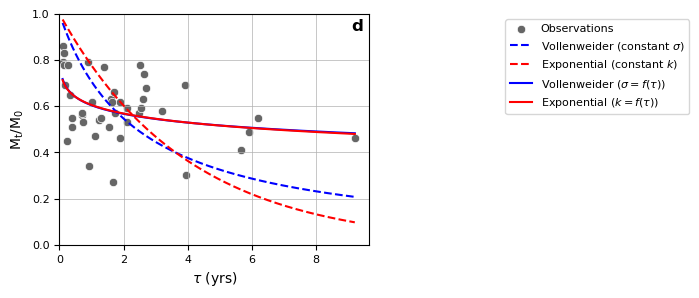

In [17]:
# Plot all models on one figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
# ax.scatter(short_tau_df['tau'], short_tau_df['TDOC'], label='Observations', color='black')
sn.scatterplot(data=short_tau_df, x='tau', y='TDOC', label='Observations', color='0.4')  # label='Observations', 

# Plot each model's fit
tau_values = np.linspace(short_tau_df['tau'].min(), short_tau_df['tau'].max(), 100000)

ax.plot(tau_values, short_fit1.eval(tau=tau_values), ls='--', label=r'Vollenweider (constant $\sigma$)', color='blue')
ax.plot(tau_values, short_fit_exp1.eval(tau=tau_values), ls='--', label='Exponential (constant $k$)', color='red')
ax.plot(tau_values, short_fit2.eval(tau=tau_values), label=r'Vollenweider ($\sigma = f(\tau$))', color='blue')
ax.plot(tau_values, short_fit_exp2.eval(tau=tau_values), label=r'Exponential ($k = f(\tau$))', color='red')

# # Also plot implied results of Catalan's regression, when rearranged for Cout/Cin
# trans_catalan = np.exp(-0.38 * tau_values ** 0.55)
# ax.plot(tau_values, trans_catalan, label="Exponential decay (Catalan et al. 2016), k=f(t)", color='orange')

# plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0, ymax=1)

# Add labels and legend
plt.ylabel('$\mathrm{M_{t}/M_{0}}$', size=10)
plt.xlabel((r'$\tau$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

ax.legend(fontsize=8, bbox_to_anchor=(2.05, 1))

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, 'd', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(f'graphs/model_results_evans-data_all-countries-short-taus_{tau_upper}_legend.png', bbox_inches='tight')
plt.show()

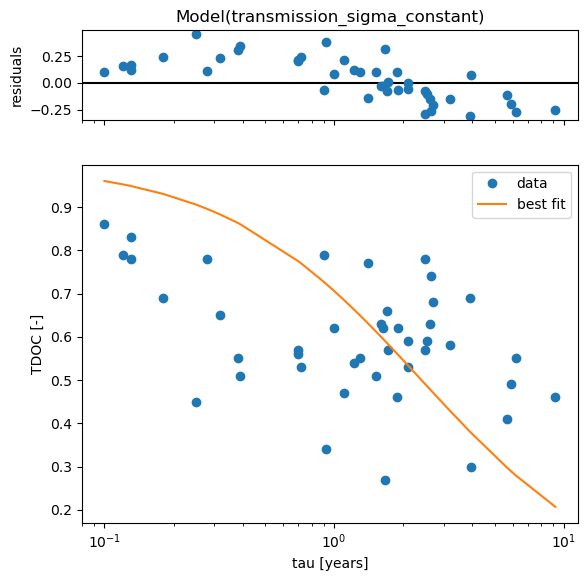

In [18]:
# Plot fit
short_fit1.plot(xlabel="tau [years]", ylabel="TDOC [-]");
plt.xscale('log')

In [13]:
# # Plot fit
# short_fit2.plot(xlabel="tau [years]", ylabel="TDOC [-]");
# plt.xscale('log')

In [14]:
# # Plot fit
# short_fit_exp.plot(xlabel="tau [years]", ylabel="TDOC [-]");
# plt.xscale('log')